Importando as bibliotecas necessárias

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycircular as pycircular
from scipy.stats import chi2_contingency
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
LE = preprocessing.LabelEncoder()
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

pd.set_option('display.max_columns', None)

Unindo os dataframes

In [121]:
df_channels = pd.read_csv(r'bases\channels.csv')
df_deliveries = pd.read_csv(r'bases\deliveries.csv')
df_drivers = pd.read_csv(r'bases\drivers.csv')
df_hubs = pd.read_csv(r'bases\hubs.csv')
df_orders = pd.read_csv(r'bases\orders.csv')
df_stores = pd.read_csv(r'bases\stores.csv')
df_payments = pd.read_csv(r'bases\payments.csv')

df = pd.merge(df_orders, df_stores, on='store_id')
df = pd.merge(df, df_hubs, on='hub_id')
df = pd.merge(df, df_channels, on='channel_id')
df = pd.merge(df, df_payments, on='payment_order_id')
df = pd.merge(df, df_deliveries, on='delivery_order_id')
df = pd.merge(df, df_drivers, on='driver_id')

df.shape

(287459, 48)

In [4]:
print(df.columns)

Index(['order_id', 'store_id', 'channel_id', 'payment_order_id',
       'delivery_order_id', 'order_status', 'order_amount',
       'order_delivery_fee', 'order_delivery_cost', 'order_created_hour',
       'order_created_minute', 'order_created_day', 'order_created_month',
       'order_moment_created', 'order_moment_accepted', 'order_moment_ready',
       'order_moment_collected', 'order_moment_in_expedition',
       'order_moment_delivering', 'order_moment_delivered',
       'order_moment_finished', 'order_metric_collected_time',
       'order_metric_paused_time', 'order_metric_production_time',
       'order_metric_walking_time', 'order_metric_expediton_speed_time',
       'order_metric_transit_time', 'order_metric_cycle_time', 'hub_id',
       'store_segment', 'store_plan_price', 'store_latitude',
       'store_longitude', 'hub_city', 'hub_latitude', 'hub_longitude',
       'channel_type', 'payment_id', 'payment_amount', 'payment_fee',
       'payment_method', 'payment_status', 'de

In [17]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
order_id,215946.0,82105757.224264,68410055.0,76148637.5,82885660.0,87904480.75,93139799.0,7048877.06835
order_amount,215946.0,88.791656,0.0,38.0,65.0,111.0,15000.0,118.405779
order_delivery_fee,215946.0,5.522793,0.0,0.0,6.0,11.0,990.0,5.710961
order_delivery_cost,215946.0,6.920633,0.0,5.0,7.0,8.0,109.0,2.379256
order_created_hour,215946.0,16.939508,0.0,15.0,17.0,22.0,23.0,6.047609
order_created_minute,215946.0,29.344734,0.0,14.0,29.0,44.0,59.0,17.222617
order_created_day,215946.0,16.075051,1.0,9.0,16.0,24.0,31.0,8.714806
order_created_month,215946.0,2.654539,1.0,2.0,3.0,4.0,4.0,1.099831
order_moment_created,215946,2021-03-07 08:04:38.129388800,2021-01-01 02:32:51,2021-02-07 00:16:31,2021-03-11 14:44:50,2021-04-03 20:49:41.500000,2021-04-30 23:59:26,NaN
order_moment_finished,215946,2021-03-07 09:01:13.881035264,2021-01-01 14:50:20,2021-02-07 01:08:34.249999872,2021-03-11 15:38:59,2021-04-03 21:40:13.750000128,2021-05-01 23:25:01,NaN


# Limpeza Inicial

In [3]:
grupo_pagamento = {
'DEBIT': 'CARD',
'CREDIT': 'CARD',
'DEBIT_STORE': 'CARD',
'CREDIT_STORE': 'CARD',
'INSTALLMENT_CREDIT_STORE': 'CARD',
'MEAL_BENEFIT': 'OTHER',
'STORE_DIRECT_PAYMENT': 'OTHER',
'PAYMENT_LINK': 'OTHER',
'MONEY': 'OTHER',
'BANK_TRANSFER_DC': 'OTHER',
'VOUCHER_DC': 'VOUCHER',
'VOUCHER_OL': 'VOUCHER',
'VOUCHER_STORE': 'VOUCHER'
}

def preparacao_inicial(df):

    #Retirar colunas não importantes
    df = df.drop(columns=['store_id','channel_id','payment_order_id','delivery_order_id','hub_id','payment_id','delivery_id', 'driver_id','order_moment_accepted', 'order_moment_ready',
        'order_moment_collected', 'order_moment_in_expedition',
        'order_moment_delivering', 'order_moment_delivered'])


    #Retirar pedidos cancelados, que estão sendo entregues e que não foram pagos
    df = df[~df['order_status'].isin(['CANCELED'])]
    df = df[~df['delivery_status'].isin(['DELIVERING'])]
    df = df[~df['payment_status'].isin(['CHARGEBACK', 'AWAITING'])]
    df['payment_method'] = df['payment_method'].replace(grupo_pagamento)
    
    df = df.drop(columns=['order_status','payment_status','delivery_status','payment_fee'])

    #Tratamento dos dados nulos
    df = df.dropna(subset=['delivery_distance_meters','store_latitude','store_longitude','order_moment_finished','order_metric_cycle_time','order_metric_transit_time'])

    df['order_delivery_cost'] = df['order_delivery_cost'].fillna(0.0)
    df['store_plan_price'] = df['store_plan_price'].fillna(0.0)

    df['order_moment_created'] = pd.to_datetime(df['order_moment_created'])
    df['order_moment_finished'] = pd.to_datetime(df['order_moment_finished'])

    #Valores inconsistentes
    df = df.drop_duplicates()
    df = df.loc[df['order_metric_transit_time'] >= 0]
    df = df.loc[df['order_metric_walking_time'] >= 0]
    df = df.loc[df['order_metric_paused_time'] >= 0]
    df = df.loc[df['order_metric_collected_time'] >= 0]
    
    return df

In [4]:
df = preparacao_inicial(df)

# Função para calcular outliers
def calcula_outliers(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    diff = q3 - q1
    lim_inf = q1 - 1.5 * diff
    lim_sup = q3 + 1.5 * diff
    outliers = column[(column < lim_inf) | (column > lim_sup)] # Definição de outliers pelos percentis e limites
    return outliers, lim_inf, lim_sup

# Função para contar outliers e calcular a porcentagem
def conta_outliers(df):
    outlier_info = pd.DataFrame(columns=['Coluna', 'Outliers', 'Porcentagem', 'lim_inf', 'lim_sup']) # Criando um novo DataFrame
    for col in df.select_dtypes(include=['int', 'float']): # Loop para verificar cada coluna numérica
        outliers, lim_inf, lim_sup = calcula_outliers(df[col]) # Chamando a função para calcular outliers
        outlier_count = len(outliers) # Verificando o tamanho da lista
        percentage = (outlier_count / len(df)) * 100 # Porcentagem de outliers
        outlier_info.loc[len(outlier_info)] = [col, outlier_count, percentage, lim_inf, lim_sup] # Atribuindo valores usando .loc[]
    return outlier_info # Retornando DataFrame




outlier_df = conta_outliers(df)
print(outlier_df)

C:\Users\matus\AppData\Local\Temp\ipykernel_12252\3383769281.py:39: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\matus\AppData\Local\Temp\ipykernel_12252\3383769281.py:40: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



                               Coluna  Outliers  Porcentagem       lim_inf  \
0                            order_id         0     0.000000  5.882133e+07   
1                        order_amount     11639     5.033516 -7.450000e+01   
2                  order_delivery_fee        64     0.027678 -1.650000e+01   
3                 order_delivery_cost      9064     3.919907  5.000000e-01   
4                  order_created_hour     20223     8.745837  4.500000e+00   
5                order_created_minute         0     0.000000 -3.100000e+01   
6                   order_created_day         0     0.000000 -1.350000e+01   
7                 order_created_month         0     0.000000 -1.000000e+00   
8         order_metric_collected_time     14631     6.327466 -3.000000e+00   
9            order_metric_paused_time     20141     8.710375 -5.000000e+00   
10       order_metric_production_time      9071     3.922934 -9.000000e+00   
11          order_metric_walking_time     10851     4.692730 -2.

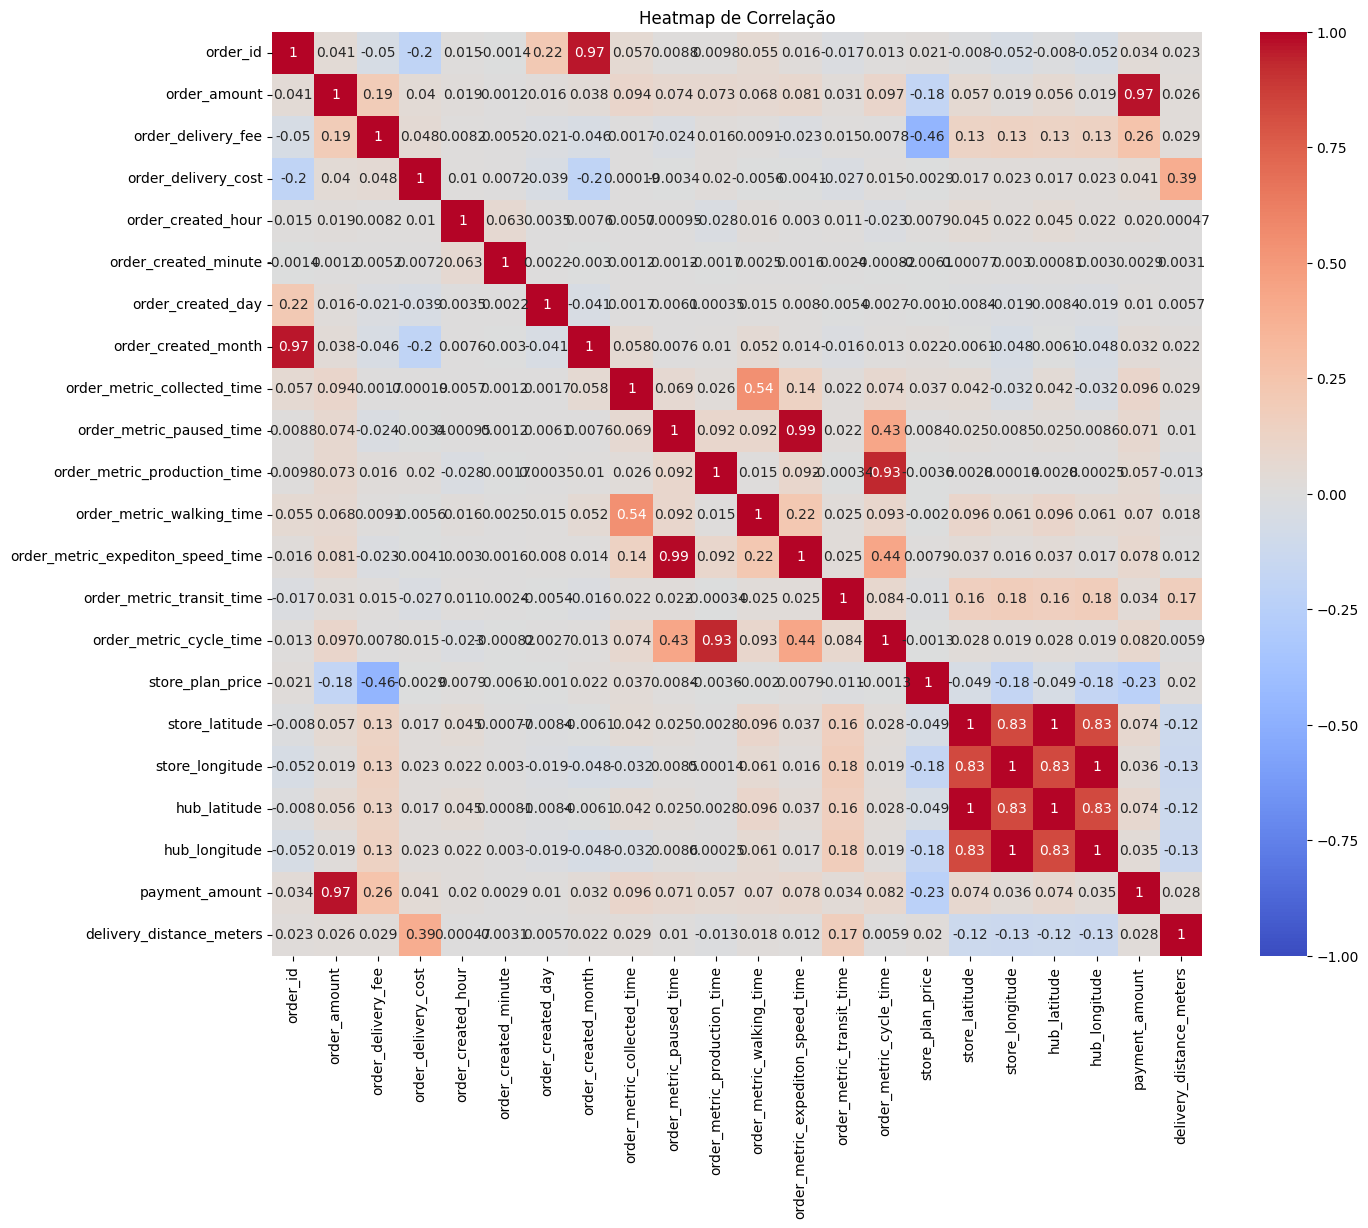

In [30]:
plt.figure(figsize=(15, 12)) 
sns.heatmap(df.select_dtypes(include=["int","float"]).corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap de Correlação')
plt.show()

# Order_metrics

Para os order_metrics de menores expressão (média dos valores menores que 8 minutos), seu valor de soma no tempo total será a ESCOLHER.

No final ver se vale mais a pena (mse_score) usar a média ou mediana

In [5]:
#Médias
avg_walking = df['order_metric_walking_time'].mean()
avg_collected = df['order_metric_collected_time'].mean()
avg_paused = df['order_metric_paused_time'].mean()

median = avg_paused + avg_walking + avg_collected

# Order_metric_production_time

In [6]:
colunas_production = ['channel_type','payment_method','order_delivery_fee','hub_longitude','hub_latitude','payment_amount','store_longitude','store_latitude','store_plan_price','order_amount','order_delivery_cost','order_metric_production_time']

#Colunas
#del_cost: 85.33 KNN
#del_cost,amount: 71.911 KNN
#del_cost,amount,plan_price: 65.14 KNN
#del_cost,amount,plan_price, latitude: 62.257 KNN
#del_cost,amount,plan_price, latitude,long: 61.7 KNN
#del_cost,amount,plan_price, latitude,long, pay_amount: 60.61 KNN
#del_cost,amount,plan_price, latitude,long, pay_amount, hub_lat: 60.60 KNN
#del_cost,amount,plan_price, latitude,long, pay_amount, hub_lat,long: 60.55 KNN
#del_cost,amount,plan_price, latitude,long, pay_amount, hub_lat,long, del_fee: 59.94 KNN
#del_cost,amount,plan_price, latitude,long, pay_amount, hub_lat,long, del_fee, hour: 60.14 KNN
#del_cost,amount,plan_price, latitude,long, pay_amount, hub_lat,long, del_fee, minute: 62.1 KNN
#del_cost,amount,plan_price, latitude,long, pay_amount, hub_lat,long, del_fee, day: 61.4 KNN
#del_cost,amount,plan_price, latitude,long, pay_amount, hub_lat,long, del_fee, month: 60.3 KNN
#del_cost,amount,plan_price, latitude,long, pay_amount, hub_lat,long, del_fee, pay_method: 59.9 KNN
#del_cost,amount,plan_price, latitude,long, pay_amount, hub_lat,long, del_fee, pay_method, channel: 59.8 KNN

df_production = df[colunas_production]
df_production = df_production.dropna(subset=['order_metric_production_time'])

df_production = df_production.loc[df_production['order_metric_production_time'] <= 43]
df_production = df_production.dropna(subset=['order_delivery_cost','order_metric_production_time'])
df_production['store_plan_price'] = df_production['store_plan_price'].fillna(0.0)

def troca1(x):
    if x == 'ONLINE':
        return 0
    elif x == 'VOUCHER':
        return 1
    elif x == 'CARD':
        return 2
    else:
        return 3
    
df_production['payment_method'] = df_production['payment_method'].apply(lambda x: troca1(x))

def troca2(x):
    if x == 'MARKETPLACE':
        return 0
    else:
        return 1
    
df_production['channel_type'] = df_production['channel_type'].apply(lambda x: troca2(x))

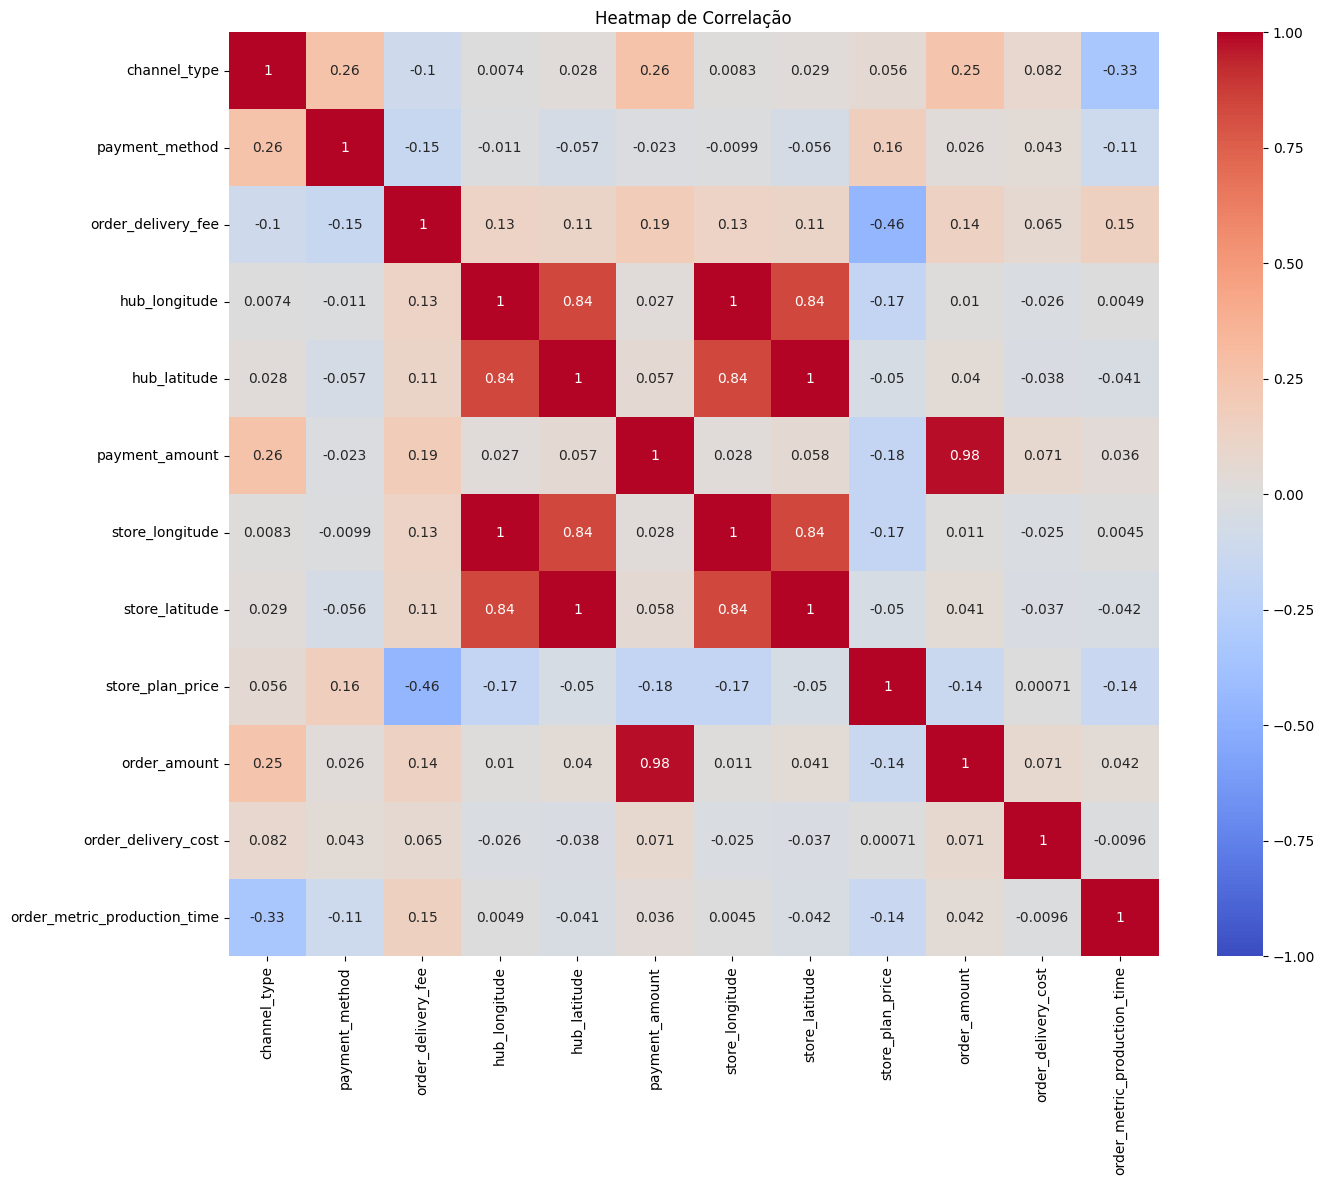

In [7]:
plt.figure(figsize=(15, 12)) 
sns.heatmap(df_production.select_dtypes(include=["int","float"]).corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap de Correlação')
plt.show()

In [8]:
print(df_production.columns)

def cat_var(tab, x):
    if x == 0:
        cat = [i for i in tab.columns if tab.dtypes[i] == 'object']
    if x == 1:
        cat = [i for i in tab.columns if (tab.dtypes[i] == 'float64' or tab.dtypes[i] == 'int64')]
    return cat

def preparacao(tab):
    dados = tab.copy()
    order_metric_production_time = dados.pop("order_metric_production_time")
    return dados, order_metric_production_time

tam_div = round(0.8 * len(df_production)) # Tamanho da separação
tab_treino = df_production.iloc[:tam_div] # Definindo parte a ser utilizada para treino
tab_valid = df_production.iloc[tam_div:] # Definindo parte a ser utilizada para verificação

# Dados
X_treino = preparacao(tab_treino)[0]
X_valid = preparacao(tab_valid)[0]

Y_treino = preparacao(tab_treino)[1]
Y_valid = preparacao(tab_valid)[1]

numk = 40
modelo_production = KNeighborsRegressor(n_neighbors=numk)

# modelo_production = LinearRegression()

modelo_production.fit(X_treino, Y_treino) # Treinando o regressor
Y_prev_valid = modelo_production.predict(X_valid) # Prevendo os valores

# Calcular o MSE
mse = mean_squared_error(Y_valid, Y_prev_valid)
print('MSE:', mse) # Exibindo o MSE

r2 = r2_score(Y_valid, Y_prev_valid)
print('R²:', r2) # Exibindo o R²


Index(['channel_type', 'payment_method', 'order_delivery_fee', 'hub_longitude',
       'hub_latitude', 'payment_amount', 'store_longitude', 'store_latitude',
       'store_plan_price', 'order_amount', 'order_delivery_cost',
       'order_metric_production_time'],
      dtype='object')
MSE: 59.79676040969899
R²: 0.2550241453999069


# Order_metric_expediton_speed_time

In [9]:
colunas_exped = ['store_latitude','store_longitude','order_delivery_fee', 'driver_type', 'order_created_month','store_plan_price','order_metric_expediton_speed_time']

#Colunas
#latitude_store: 17.86 KNN
#latitude,longitude_store: 17.854 KNN
#latitude,longitude_store, hub_latitude: 17.858 KNN
#latitude,longitude_store, hub_latitude,longitude: 17.858 KNN
#latitude,longitude_store, plan_price: 17.08 KNN
#latitude,longitude_store, plan_price,order_amount: 17.907 KNN
#latitude,longitude_store, plan_price, delivery_fee: 16.86 KNN
#latitude,longitude_store, plan_price, delivery_fee e cost: 17.9 KNN
#latitude,longitude_store, plan_price, delivery_fee, hour: 17.115 KNN
#latitude,longitude_store, plan_price, delivery_fee, day: 17.8 KNN
#latitude,longitude_store, plan_price, delivery_fee, month: 16.84 KNN
#latitude,longitude_store, plan_price, delivery_fee, month, payment_amount: 17.96 KNN
#latitude,longitude_store, plan_price, delivery_fee, month, : 18 RL
#latitude,longitude_store, plan_price, delivery_fee, month, modal: 16.869 KNN
#latitude,longitude_store, plan_price, delivery_fee, month, type: 16.84 KNN


df_exped = df[colunas_exped]
df_exped = df_exped.dropna(subset=['order_metric_expediton_speed_time'])

df_exped = df_exped.loc[df_exped['order_metric_expediton_speed_time'] <= 25]

def type(x):
    if x == 'FREELANCE':
        return 0
    else:
        return 1
    
df_exped['driver_type'] = df_exped['driver_type'].apply(lambda x: type(x))

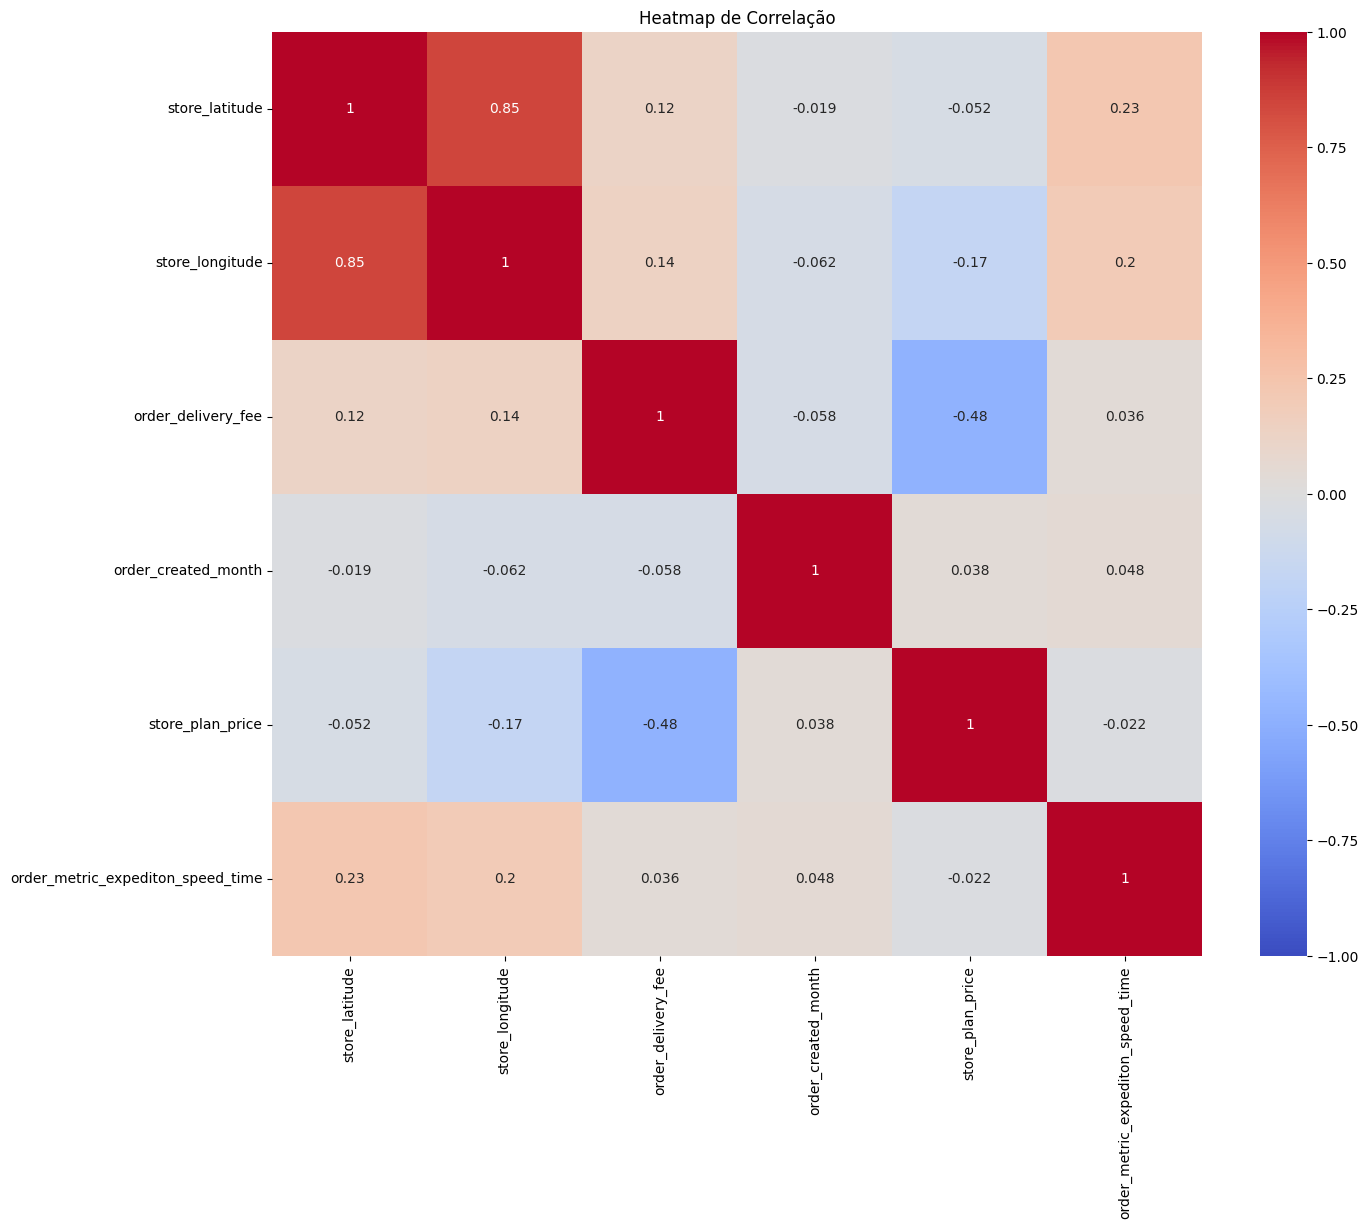

In [77]:
plt.figure(figsize=(15, 12)) 
sns.heatmap(df_exped.select_dtypes(include=["int","float"]).corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap de Correlação')
plt.show()

In [78]:
nomes_colunas_numericas = df_exped.select_dtypes(exclude=['object','datetime']).columns

for coluna in nomes_colunas_numericas:
    data1 = df_exped[coluna]
    data2 = df_exped['order_metric_expediton_speed_time']

    t_statistic, p_value = ttest_ind(data1, data2)

    print("\n")
    print(coluna)
    print("Estatística t:", t_statistic)
    print("Valor p:", p_value)



store_latitude
Estatística t: -2994.2679029758106
Valor p: 0.0


store_longitude
Estatística t: -4872.093621555128
Valor p: 0.0


order_delivery_fee
Estatística t: -96.62890839747254
Valor p: 0.0


order_created_month
Estatística t: -448.7918172243563
Valor p: 0.0


store_plan_price
Estatística t: 311.5179366081895
Valor p: 0.0


order_metric_expediton_speed_time
Estatística t: 0.0
Valor p: 1.0


In [10]:
print(df_exped.columns)

def cat_var(tab, x):
    if x == 0:
        cat = [i for i in tab.columns if tab.dtypes[i] == 'object']
    if x == 1:
        cat = [i for i in tab.columns if (tab.dtypes[i] == 'float64' or tab.dtypes[i] == 'int64')]
    return cat

def preparacao(tab):
    dados = tab.copy()
    order_metric_expediton_speed_time = dados.pop("order_metric_expediton_speed_time")
    return dados, order_metric_expediton_speed_time

tam_div = round(0.8 * len(df_exped)) # Tamanho da separação
tab_treino = df_exped.iloc[:tam_div] # Definindo parte a ser utilizada para treino
tab_valid = df_exped.iloc[tam_div:] # Definindo parte a ser utilizada para verificação

# Dados
X_treino = preparacao(tab_treino)[0]
X_valid = preparacao(tab_valid)[0]

Y_treino = preparacao(tab_treino)[1]
Y_valid = preparacao(tab_valid)[1]

numk = 800
modelo_exped = KNeighborsRegressor(n_neighbors=numk)

modelo_exped.fit(X_treino, Y_treino) # Treinando o regressor
Y_prev_valid = modelo_exped.predict(X_valid) # Prevendo os valores

# Calcular o MSE
mse = mean_squared_error(Y_valid, Y_prev_valid)
print('MSE:', mse) # Exibindo o MSE

r2 = r2_score(Y_valid, Y_prev_valid)
print('R²:', r2) # Exibindo o R²


Index(['store_latitude', 'store_longitude', 'order_delivery_fee',
       'driver_type', 'order_created_month', 'store_plan_price',
       'order_metric_expediton_speed_time'],
      dtype='object')
MSE: 16.808799261272906
R²: 0.14490688460641954


# Order_metric_transit_time

Para prever o tempo de trânsito, não usaremos todas as categorias.

In [11]:
colunas_transito = ['delivery_distance_meters','order_amount','order_created_hour','order_created_minute','order_created_month', 'order_created_day','order_delivery_fee','store_longitude','order_delivery_cost','store_latitude','order_metric_transit_time']

#Colunas e modelos com melhor MSE
#delivery_distance_meters: 77.205 KNN
#distance, modal : 77.215 KNN
#distance, order_amount: 77.179 KNN
#distance, order_amount, hour: 77.174 KNN
#distance, order_amount, hour, latitude: 75.197 LR
#distance, order_amount, hour, latitude, delivery_cost: 74.222 LR
#distance, order_amount, hour, latitude, delivery_cost, delivery_fee: 74.191 LR
#distance, order_amount, hour, latitude, delivery_cost, delivery_fee, longitude: 73.58 LR
#distance, order_amount, hour, latitude, delivery_cost, delivery_fee, longitude, type: 73.58 LR
#distance, order_amount, hour, latitude, delivery_cost, delivery_fee, longitude, dia: 73.569 LR
#distance, order_amount, hour, latitude, delivery_cost, delivery_fee, longitude, dia, mes: 73.447 LR
#distance, order_amount, hour, latitude, delivery_cost, delivery_fee, longitude, dia, mes, minuto: 73.447 LR
#distance, order_amount, hour, latitude, delivery_cost, delivery_fee, longitude, dia, mes, hour_angle: 73.309 LR
#distance, order_amount, hour,latitude, delivery_cost, delivery_fee, longitude, dia, mes, minuto, hour_angle: 73.303 LR

#Limpeza
df_transito = df[colunas_transito]
df_transito = df_transito.dropna(subset=['order_metric_transit_time'])

df_transito = df_transito.loc[df_transito['order_metric_transit_time'] <= 50]
df_transito = df_transito.loc[df_transito['delivery_distance_meters'] <= 3500]

#Variável de ângulo da hora

# Calculando a representação circular para as horas
df_transito['hour_angle'] = (df_transito['order_created_hour'] % 12) * 30 + (df_transito['order_created_minute'] / 60) * 30
# Normalizando os ângulos para o intervalo [0, 360)
df_transito['hour_angle'] = df_transito['hour_angle'] % 360

colunas = df_transito.columns.tolist()

# Mover 'coluna_alvo' para o início da lista
colunas.insert(0, colunas.pop(colunas.index('hour_angle')))

# Reorganizar as colunas no DataFrame
df_transito = df_transito[colunas]


- Variáveis numéricas: T-test

OBS: Generally, any t-value greater than +3.17 or less than - 3.17 is acceptable.

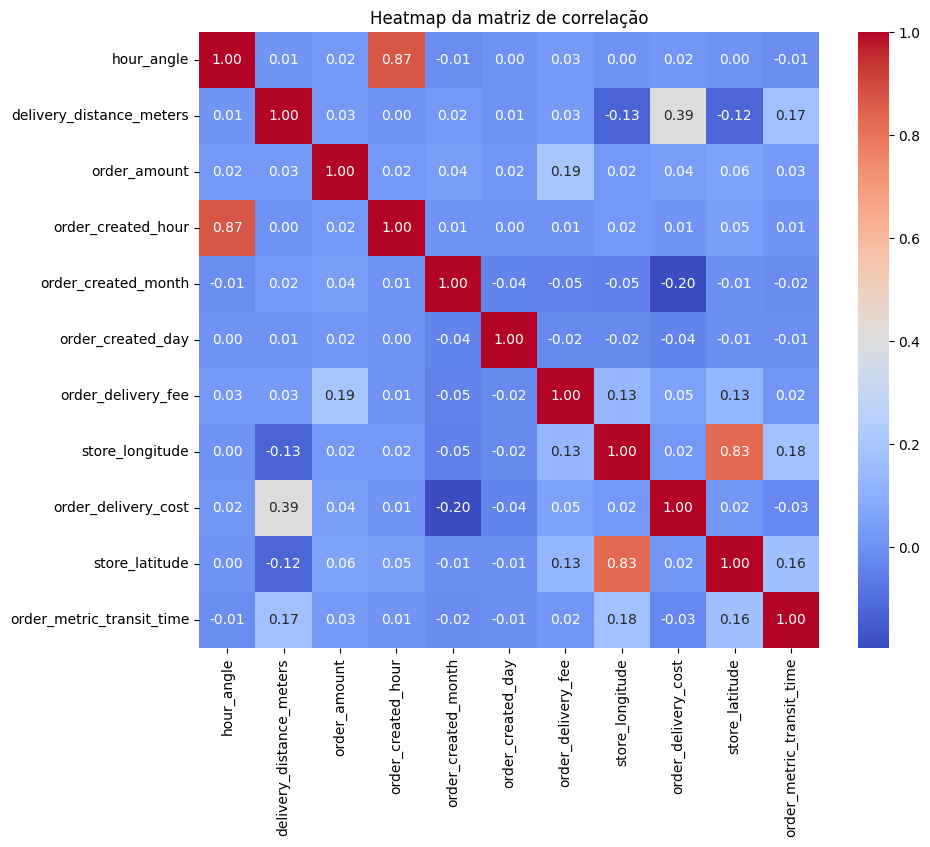

In [177]:
plt.figure(figsize=(10, 8))  # Tamanho da figura


# Substitua df pelo seu DataFrame
sns.heatmap(df_transito.corr(), annot=True, cmap='coolwarm', fmt=".2f")

# Adicione um título
plt.title('Heatmap da matriz de correlação')

# Exiba o plot
plt.show()

In [178]:
nomes_colunas_numericas = df_transito.select_dtypes(exclude=['object','datetime']).columns

for coluna in nomes_colunas_numericas:
    data1 = df_transito[coluna]
    data2 = df_transito['order_metric_transit_time']

    t_statistic, p_value = ttest_ind(data1, data2)

    print("\n")
    print(coluna)
    print("Estatística t:", t_statistic)
    print("Valor p:", p_value)



hour_angle
Estatística t: 688.8038729335409
Valor p: 0.0


delivery_distance_meters
Estatística t: 789.3487707308802
Valor p: 0.0


order_amount
Estatística t: 278.85180098523773
Valor p: 0.0


order_created_hour
Estatística t: 17.67290287995023
Valor p: 7.265732446721026e-70


order_created_month
Estatística t: -653.8473450549106
Valor p: 0.0


order_created_day
Estatística t: -14.62227822852405
Valor p: 2.091811608158669e-48


order_delivery_fee
Estatística t: -443.04710843536486
Valor p: 0.0


store_longitude
Estatística t: -2856.119194941881
Valor p: 0.0


order_delivery_cost
Estatística t: -464.412817712288
Valor p: 0.0


store_latitude
Estatística t: -1881.356044924922
Valor p: 0.0


order_metric_transit_time
Estatística t: 0.0
Valor p: 1.0


Modelo

In [12]:
print(df_transito.columns)

def cat_var(tab, x):
    if x == 0:
        cat = [i for i in tab.columns if tab.dtypes[i] == 'object']
    if x == 1:
        cat = [i for i in tab.columns if (tab.dtypes[i] == 'float64' or tab.dtypes[i] == 'int64')]
    return cat

def preparacao(tab):
    dados = tab.copy()
    order_metric_transit_time = dados.pop("order_metric_transit_time")
    return dados, order_metric_transit_time

tam_div = round(0.8 * len(df_transito)) # Tamanho da separação
tab_treino = df_transito.iloc[:tam_div] # Definindo parte a ser utilizada para treino
tab_valid = df_transito.iloc[tam_div:] # Definindo parte a ser utilizada para verificação

# Dados
X_treino = preparacao(tab_treino)[0]
X_valid = preparacao(tab_valid)[0]

Y_treino = preparacao(tab_treino)[1]
Y_valid = preparacao(tab_valid)[1]

#LinearRegression
modelo_transito = LinearRegression()

modelo_transito.fit(X_treino, Y_treino) # Treinando o regressor
Y_prev_valid = modelo_transito.predict(X_valid) # Prevendo os valores

# Calcular o MSE
mse = mean_squared_error(Y_valid, Y_prev_valid)
print('MSE:', mse) # Exibindo o MSE

r2 = r2_score(Y_valid, Y_prev_valid)
print('R²:', r2) # Exibindo o R²


Index(['hour_angle', 'delivery_distance_meters', 'order_amount',
       'order_created_hour', 'order_created_minute', 'order_created_month',
       'order_created_day', 'order_delivery_fee', 'store_longitude',
       'order_delivery_cost', 'store_latitude', 'order_metric_transit_time'],
      dtype='object')
MSE: 73.30397643996352
R²: 0.08510161385816062


# Modelo Final

Agora que todos os order_metric já tem seus modelos agora é necessária a junção de todos.

Funções preparações:

Como cada modelo utilizou de colunas diferente e meios diferentes, para prever em um novo dataframe essas funções serão criadas para facilitar o processo de dataprep

In [157]:
#Production_time
def prep_production(df, modelo):
    colunas_production = ['channel_type','payment_method','order_delivery_fee','hub_longitude','hub_latitude','payment_amount','store_longitude','store_latitude','store_plan_price','order_amount','order_delivery_cost']

    df_production = df[colunas_production]

    # Verificar se há valores NaN em cada coluna
    for coluna in df_production.columns:
        if df_production[coluna].isnull().any():
            df_production[coluna] = df_production[coluna].fillna(0.0)

    df_production['payment_method'] = df_production['payment_method'].apply(lambda x: troca1(x))
        
    df_production['channel_type'] = df_production['channel_type'].apply(lambda x: troca2(x))

    Y_prev = modelo.predict(df_production)
    
    return Y_prev   

In [158]:
#Expedition_time

def prep_exped(df, modelo):
    colunas_exped = ['store_latitude','store_longitude','order_delivery_fee', 'driver_type', 'order_created_month','store_plan_price']

    df_exped = df[colunas_exped]

    # Verificar se há valores NaN em cada coluna
    for coluna in df_exped.columns:
        if df_exped[coluna].isnull().any():
            df_exped[coluna] = df_exped[coluna].fillna(0.0)

    df_exped['driver_type'] = df_exped['driver_type'].apply(lambda x: type(x))

    Y_prev = modelo.predict(df_exped)
    
    return Y_prev

In [159]:
#Transit_time

def prep_transito(df, modelo):
    colunas_transito = ['delivery_distance_meters','order_amount','order_created_hour','order_created_minute','order_created_month', 'order_created_day','order_delivery_fee','store_longitude','order_delivery_cost','store_latitude']

    df_transito = df[colunas_transito]

    for coluna in df_transito.columns:
        if df_transito[coluna].isnull().any():
            df_transito[coluna] = df_transito[coluna].fillna(0.0)

    #Variável de ângulo da hora

    # Calculando a representação circular para as horas
    df_transito['hour_angle'] = (df_transito['order_created_hour'] % 12) * 30 + (df_transito['order_created_minute'] / 60) * 30
    # Normalizando os ângulos para o intervalo [0, 360)
    df_transito['hour_angle'] = df_transito['hour_angle'] % 360

    colunas = df_transito.columns.tolist()

    # Mover 'coluna_alvo' para o início da lista
    colunas.insert(0, colunas.pop(colunas.index('hour_angle')))

    # Reorganizar as colunas no DataFrame
    df_transito = df_transito[colunas]

    Y_prev = modelo.predict(df_transito)

    return Y_prev

In [75]:
print(df_payments['payment_order_id'].value_counts().unique())

[1]


In [126]:
# Remover as linhas duplicadas com base na coluna 'order_id'
df_payments = df_payments.drop_duplicates(subset=['payment_order_id'])
df_drivers = df_drivers.drop_duplicates(subset=['driver_id'])
df_deliveries = df_deliveries.drop_duplicates(subset=['delivery_order_id'])

In [160]:
df_test = pd.read_csv(r'test.csv')


df_test = pd.merge(df_test, df_stores, on='store_id')
df_test = pd.merge(df_test, df_hubs, on='hub_id')
df_test = pd.merge(df_test, df_channels, on='channel_id')
df_test = pd.merge(df_test, df_payments, on='payment_order_id', how='left')
df_test = pd.merge(df_test, df_deliveries, on='delivery_order_id', how='left')
df_test = pd.merge(df_test, df_drivers, on='driver_id', how='left')

df_test.shape

(84107, 35)

In [161]:
def preparacao_inicial(df):

    #Retirar colunas não importantes
    df = df.drop(columns=['store_id','channel_id','payment_order_id','delivery_order_id','hub_id','payment_id','delivery_id', 'driver_id'])

    df['payment_method'] = df['payment_method'].replace(grupo_pagamento)
    
    df = df.drop(columns=['order_status','payment_status','delivery_status','payment_fee'])

    df['order_delivery_cost'] = df['order_delivery_cost'].fillna(0.0)
    df['store_plan_price'] = df['store_plan_price'].fillna(0.0)
    
    return df

In [162]:
df_test = preparacao_inicial(df_test)

df_test.shape

(84107, 23)

In [163]:
y_pred_production = prep_production(df_test,modelo_production)
print(len(y_pred_production))
y_pred_exped = prep_exped(df_test,modelo_exped)
print(len(y_pred_exped))
y_pred_transito = prep_transito(df_test,modelo_transito)
print(len(y_pred_transito))

order_metric_cycle_time = []

for k in range(len(y_pred_transito)):
    # Calcular a soma dos valores das três colunas mais a mediana para cada índice k
    cycle_time = y_pred_transito[k] + y_pred_exped[k] + y_pred_production[k] + median
    # Adicionar o resultado à lista
    order_metric_cycle_time.append(cycle_time)

print(order_metric_cycle_time)

84107
84107
84107
[56.963434821611386, 58.97571542642686, 54.216351527471005, 56.19909940901492, 54.6975090997925, 53.84646093870958, 57.420526154402864, 59.469303361015584, 47.842231928295796, 46.306519033796214, 65.34941843285634, 58.16146620212767, 63.272789454071464, 60.80179918069118, 57.39105851784578, 57.212078442962614, 58.490682185006605, 61.70500090270835, 57.89272672544778, 54.01215822243259, 63.05737917478032, 47.69697604405248, 54.52804545214717, 59.65449758419253, 60.79958388255285, 55.019800055040925, 69.83674043565335, 61.87727360130398, 52.28918975001122, 50.17162049878646, 44.73668118352121, 48.012332849377955, 68.17559303658201, 61.08309683844621, 48.68019837738559, 57.760311633841866, 61.107772201466915, 56.96788855887722, 59.518882397894075, 64.8632566652248, 49.15675672796715, 57.50900782450678, 60.609360847099566, 58.51504252576322, 48.52373671887798, 52.80399483241196, 53.041371586459164, 53.86055229673926, 61.2204245415111, 59.12314145057481, 58.35194707798921,

In [164]:
print(len(order_metric_cycle_time))

84107


In [166]:
data = {'order_id': df_test['order_id'], 'order_metric_cycle_time': order_metric_cycle_time}
df_result = pd.DataFrame(data)

df_result.shape

# Salvar o DataFrame em um arquivo CSV
df_result.to_csv('resultado.csv', index=False)

In [134]:
df_result.shape

(83720, 2)

In [115]:
colunas_transito = ['delivery_distance_meters','order_amount','order_created_hour','order_created_minute','order_created_month', 'order_created_day','order_delivery_fee','store_longitude','order_delivery_cost','store_latitude']

df_transito = df_test[colunas_transito]

df_test.shape

(86384, 23)